In [1]:
%matplotlib inline
# Load all necessary packages
import sys
import pandas  as pd
import numpy   as np
import seaborn as sns
sns.set()
sns.set_context("talk")
import matplotlib.pyplot as plt
# Import IBM's AI Fairness tooolbox
from aif360.datasets         import BinaryLabelDataset
from aif360.metrics          import BinaryLabelDatasetMetric
from aif360.metrics          import ClassificationMetric
from aif360.metrics.utils    import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.lfr import LFR
# Import scikit-learn core slibraries
from sklearn.metrics         import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split  
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import balanced_accuracy_score
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.metrics         import accuracy_score
from IPython.display         import Markdown, display
from typing                  import List, Union, Dict
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned Adult dataset
Adult_df = pd.read_csv('./input/adult-cleaned.csv')
# The AIF demo drops the following columns - we'll try the same
#Adult_df.drop(["Fnlwgt", "NativeCountry", "Relationship", "MaritalStatus"],axis=1,inplace=True)
Adult_df.drop(["Fnlwgt"],axis=1,inplace=True)

In [3]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'Gender'
priv_grp            = 1  # Males 
unpriv_grp          = 0  # Females  
lab                 = 'Income'
fav_label           = 1 # Income over £50K
unfav_label         = 0 # Income under £50K
privileged_groups   = [{protected_attr: priv_grp}]   # Males
unprivileged_groups = [{protected_attr: unpriv_grp}] # Females

In [4]:
# Create a Binary Label Dataset to use with AIF360 APIs
X = Adult_df.drop(lab,axis=1)
y = Adult_df[lab]

In [5]:
Adult_bld = BinaryLabelDataset(df=pd.concat((X, y), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)

In [6]:
# Create train and test datasets
Adult_train_bld, Adult_test_bld = Adult_bld.split([0.8], shuffle=True, seed=101)

In [7]:
#Scale the train and test datasets
scaler = MinMaxScaler(copy=False)
Adult_train_bld.features = scaler.fit_transform(Adult_train_bld.features)
Adult_test_bld.features  = scaler.fit_transform(Adult_test_bld.features)

In [8]:
#Convert train and test to dataframes
Adult_train_df, d = Adult_train_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)
Adult_test_df,  d = Adult_test_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [9]:
# First test whether it is possible to predict the Sensitive Variable from the whole original dataset
X_se_train = Adult_train_df.drop(protected_attr,axis=1)
y_se_train = Adult_train_df[protected_attr]
X_se_test  = Adult_test_df.drop(protected_attr,axis=1)
y_se_test  = Adult_test_df[protected_attr]

Se_BiasedLogModel = LogisticRegression(random_state=101)
Se_BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_BiasedLogModel.fit(X_se_train, y_se_train) 
Se_BiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_BiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_BiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.7607738765482649
Biased Random Forest       validation accuracy: 0.8003889855665882

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.6952920907607211
Biased Random Forest       balanced accuracy  : 0.7569811626718649


In [10]:
# Next get the number of labels from the training dataset
print('Train ds Before - Income value counts:')
print(Adult_train_df.Income.value_counts())
print('Train ds Before - Gender value counts:')
print(Adult_train_df.Gender.value_counts())

Train ds Before - Income value counts:
0.0    29750
1.0     9323
Name: Income, dtype: int64
Train ds Before - Gender value counts:
1.0    26143
0.0    12930
Name: Gender, dtype: int64


In [11]:
# Determine the baseline model accuracy for Logistic Regression and Random Forest Classifiers
X_train = Adult_train_df.drop(lab,axis=1)
y_train = Adult_train_df[lab]
X_test  = Adult_test_df.drop(lab,axis=1)
y_test  = Adult_test_df[lab]
BiasedLogModel = LogisticRegression(random_state=101)
BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
BiasedLogModel.fit(X_train, y_train) 
BiasedRfcModel.fit(X_train, y_train)
BiasedLogPredictions = BiasedLogModel.predict(X_test)
BiasedRfcPredictions = BiasedRfcModel.predict(X_test)
print(f"Biased Logistic regression validation accuracy: {BiasedLogModel.score(X_test, y_test)}")
print(f"Biased Random Forest       validation accuracy: {BiasedRfcModel.score(X_test, y_test)}")
print('')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test, BiasedLogPredictions)}")
print(f"Biased Random forest balanced accuracy        : {balanced_accuracy_score(y_test, BiasedRfcPredictions)}")

Biased Logistic regression validation accuracy: 0.8195311700276384
Biased Random Forest       validation accuracy: 0.8344764049544477

Biased Logistic regression balanced accuracy  : 0.6914758971792736
Biased Random forest balanced accuracy        : 0.6781526807126022


In [12]:
#Test for equality of odds. 
Test_Log_bld = Adult_test_bld.copy(deepcopy=True)
Test_Rfc_bld = Adult_test_bld.copy(deepcopy=True)
TestLogPredictions = BiasedLogModel.predict(X_test)
TestRfcPredictions = BiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(Adult_test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Adult_test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [13]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.17240932599510445
Log average_odds_difference:     -0.17240932599510445
 
Rfc average_abs_odds_difference: 0.10648112965040518
Rfc average_odds_difference:     -0.10648112965040518


In [14]:
# Create the binary label dataset metric class for the training dataset
metric_train_bld = BinaryLabelDatasetMetric(Adult_train_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print("Base Rate                     :%f" % metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))
display(Markdown("#### Biased training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

#### Biased training dataset

Number of instances           : 39073.0
Base Rate                     :0.238605
Consistency                   : [0.83263123]
Disparate Impact              : 0.3620832314871518
Mean Difference               : -0.19293913814906824
Statistical Parity Difference : -0.19293913814906824
# of positives(privileged)    : 7907.0
# of positives(non-privileged): 1416.0
Total positive instances"     : 9323.0
# of negatives(privileged)    : 18236.0
# of negatives(non-privileged): 11514.0
Total negative instances"     : 29750.0


#### Biased training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.192939


In [15]:
# Fit the Learning Fair Representations on the biased training data
print('Interval : Optimization objective value for the interval')
TR = LFR(unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups,verbose=1, seed=101)
TR = TR.fit(Adult_train_bld)

Interval : Optimization objective value for the interval
250 21849.304262405436
500 21186.80799027204
750 21054.782510903264
1000 20731.27355023851
1250 20550.19550639173
1500 20272.674031275958
1750 20120.28067033731
2000 19974.152501767796
2250 19643.61615476599
2500 19261.746064233088
2750 18583.12398143145
3000 31976.33285234392
3250 17324.385232441797
3500 16990.71487231314
3750 16732.202376687987
4000 16571.817875708737
4250 16453.15483567401
4500 16183.432041033486
4750 16129.397964549864
5000 15842.891201732013


In [16]:
# Transform training data and align features
Adult_train_lfr = TR.transform(Adult_train_bld)

In [17]:
display(Markdown("#### Transformed training dataset"))
from sklearn.metrics import classification_report
thresholds = np.linspace(0.1, 0.9, 9)
for threshold in thresholds:
    # Transform training data and align features
    Adult_train_lfr = TR.transform(Adult_train_bld,threshold=threshold)
    metric_train_lfr = BinaryLabelDatasetMetric(Adult_train_lfr, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("Classification threshold = %f" % threshold)
    print('Consistency                   :', metric_train_lfr.consistency())
    print('Disparate Impact              :', metric_train_lfr.disparate_impact())
    print('Mean Difference               :', metric_train_lfr.mean_difference())
    print('')

#### Transformed training dataset

Classification threshold = 0.100000
Consistency                   : [0.99248074]
Disparate Impact              : 0.46714881224619065
Mean Difference               : -0.4476129340267532

Classification threshold = 0.200000
Consistency                   : [0.99318199]
Disparate Impact              : 0.3189532117367169
Mean Difference               : -0.4270512182993535

Classification threshold = 0.300000
Consistency                   : [0.9945026]
Disparate Impact              : 0.22746678527865372
Mean Difference               : -0.33279535876493904

Classification threshold = 0.400000
Consistency                   : [0.99607402]
Disparate Impact              : 0.1772203326714131
Mean Difference               : -0.24236798447375768

Classification threshold = 0.500000
Consistency                   : [0.99761472]
Disparate Impact              : 0.11361043740213958
Mean Difference               : -0.18102107159507236

Classification threshold = 0.600000
Consistency                   : [0

In [18]:
threshold = 0.9 # Chosen because the disparate impact is closest to 1.
Adult_train_lfr = TR.transform(Adult_train_bld,threshold=threshold)

In [19]:
metric_train_lfr = BinaryLabelDatasetMetric(Adult_train_lfr, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [20]:
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_lfr.mean_difference())
print('Number of instances           :', metric_train_lfr.num_instances())
print("Base Rate                     :%f" % metric_train_lfr.base_rate())
print('Consistency                   :', metric_train_lfr.consistency())
print('Disparate Impact              :', metric_train_lfr.disparate_impact())
print('Mean Difference               :', metric_train_lfr.mean_difference())
print('Statistical Parity Difference :', metric_train_lfr.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_lfr.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_lfr.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_lfr.num_positives(privileged=True)+metric_train_lfr.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_lfr.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_lfr.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_lfr.num_negatives(privileged=True)+metric_train_lfr.num_negatives(privileged=False))
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.008517
Number of instances           : 39073.0
Base Rate                     :0.006859
Consistency                   : [0.99972871]
Disparate Impact              : 0.11987472831818641
Mean Difference               : -0.008517449938243462
Statistical Parity Difference : -0.008517449938243462
# of positives(privileged)    : 253.0
# of positives(non-privileged): 15.0
Total positive instances"     : 268.0
# of negatives(privileged)    : 25890.0
# of negatives(non-privileged): 12915.0
Total negative instances"     : 38805.0


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.192939


In [21]:
# Convert the transformed Binary Labelled Datasets to a pandas dataframe for consistency 
Adult_train_lfr_df, d = Adult_train_lfr.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [22]:
# Determine the transformed model accuracy for Logistic Regression and Random Forest Classifiers
X_lfr_train = Adult_train_lfr_df.drop(lab,axis=1)
y_lfr_train = Adult_train_lfr_df[lab]
X_lfr_test  = Adult_test_df.drop(lab,axis=1)
y_lfr_test  = Adult_test_df[lab]

UnbiasedLogModel = LogisticRegression(random_state=101)
UnbiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
UnbiasedLogModel.fit(X_lfr_train, y_lfr_train) 
UnbiasedRfcModel.fit(X_lfr_train, y_lfr_train) 
UnbiasedLogPredictions = UnbiasedLogModel.predict(X_lfr_test)
UnbiasedRfcPredictions = UnbiasedRfcModel.predict(X_lfr_test)

print(f"Unbiased Logistic regression validation accuracy: {UnbiasedLogModel.score(X_lfr_test, y_lfr_test)}")
print(f"Unbiased Random Forest       validation accuracy: {UnbiasedRfcModel.score(X_lfr_test, y_lfr_test)}")
print('')
print(f"UnBiased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_lfr_test, UnbiasedLogPredictions)}")
print(f"Unbiased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_lfr_test, UnbiasedRfcPredictions)}")

Unbiased Logistic regression validation accuracy: 0.7582147609786057
Unbiased Random Forest       validation accuracy: 0.7581123963558194

UnBiased Logistic regression balanced accuracy  : 0.5004230118443317
Unbiased Random Forest       balanced accuracy  : 0.5002115059221658


In [23]:
#Test for equality of odds. 
Test_Log_bld = Adult_test_bld.copy(deepcopy=True)
Test_Rfc_bld = Adult_test_bld.copy(deepcopy=True)
TestLogPredictions = UnbiasedLogModel.predict(X_test)
TestRfcPredictions = UnbiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(Adult_test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Adult_test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [24]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.0028328611898017
Log average_odds_difference:     0.0028328611898017
 
Rfc average_abs_odds_difference: 0.00141643059490085
Rfc average_odds_difference:     0.00141643059490085


Accuracy:


,LogReg,RFC
Biased,0.819531,0.834476
Fair,0.758215,0.758112


AUC:


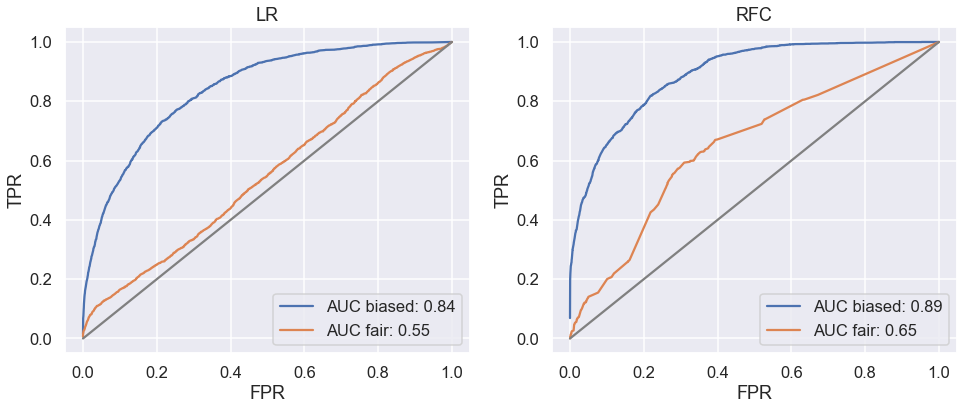

In [25]:
# Plot the AUC
%matplotlib inline
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray], title: str='', ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, y=tpr, ci=None, ax=ax)
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray',ax=ax)
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [BiasedLogModel.score(X_test, y_test), 
                                 UnbiasedLogModel.score(X_lfr_test, y_lfr_test)],
                      'RFC': [BiasedRfcModel.score(X_test, y_test),
                              UnbiasedRfcModel.score(X_lfr_test, y_lfr_test)]}, 
                      index =['Biased', 'Fair']))

print('AUC:')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
plot_auc(y_test, 
         {'AUC biased': BiasedLogModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedLogModel.predict_proba(X_lfr_test)[:, 1]},
         title='LR', ax=ax[0]) 
plot_auc(y_test, 
         {'AUC biased': BiasedRfcModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedRfcModel.predict_proba(X_lfr_test)[:, 1]},
         title='RFC', ax=ax[1]) 
plt.show()

In [26]:
# Define function to display feature importance
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier], names: List[str],scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names, 'importance': imp,
                         'std': var}).sort_values('importance', ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

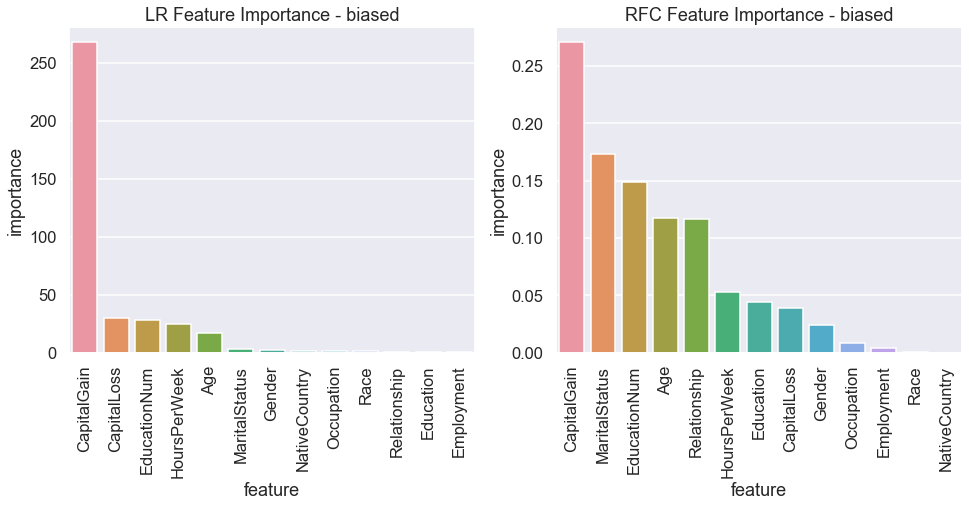

In [27]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedLogModel, names=X_train.columns.tolist(),
                                                scale=X_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - biased')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedRfcModel, names=X_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - biased')

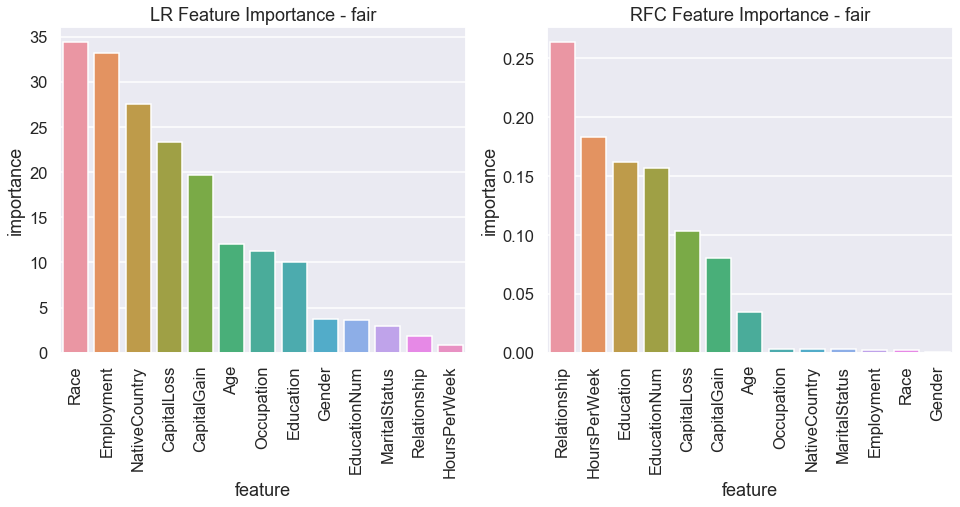

In [28]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedLogModel, names=X_lfr_train.columns.tolist(), 
                                                scale=X_lfr_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - fair')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedRfcModel, names=X_lfr_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - fair')

In [29]:
#Define function to plot metrics against thresholds
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true), axis=1),label_names=[lab],
                                  protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label, unfavorable_label=unfav_label)

    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1] # for all the rows, retain the 2nd value.
                                       # preds will contain a single column table of all 
                                       # probabilities that the classification will be 1.
    accuracy          = []
    balanced_accuracy = []
    disp_impact       = []
    average_abs_odds_difference = []
    avg_odd_diff = []
    equal_opportunity_difference = []
    error_rate = []
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100) # generate 100 evenly spaced values from 0.01->0.99 
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1  # labels is a structured dataset attribute.
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        accuracy.append(valid_metric.accuracy())
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
#        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))
        disp_impact.append(np.abs(valid_metric.disparate_impact()))
        average_abs_odds_difference.append(valid_metric.average_abs_odds_difference())
        avg_odd_diff.append(valid_metric.average_odds_difference())
        equal_opportunity_difference.append(valid_metric.equal_opportunity_difference())
        error_rate.append(valid_metric.error_rate())

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'accuracy': accuracy,
                            'balanced_accuracy': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'average_abs_odds_difference': average_abs_odds_difference,
                            'avg_odds_diff': avg_odd_diff,
                            'equal_opportunity_diff': equal_opportunity_difference},
                            index=thresh)
#'error_rate': error_rate},
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

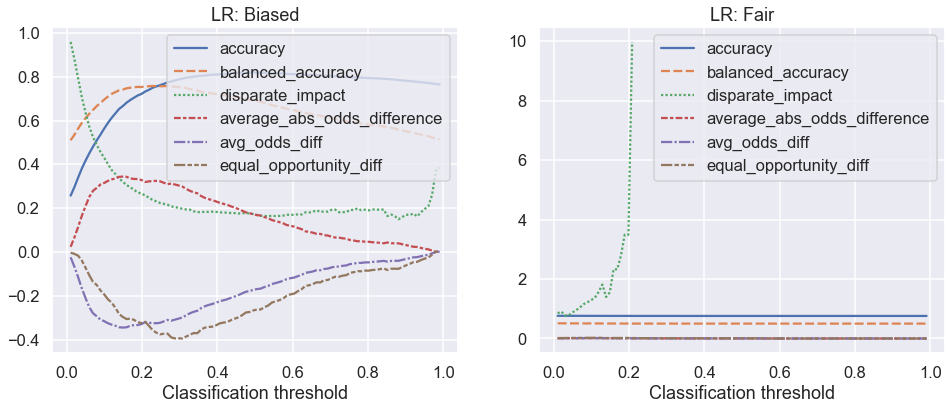

In [30]:
# Plot for Logistic Regression Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
with warnings.catch_warnings():
     warnings.simplefilter('ignore', RuntimeWarning)
    
     plot_metrics(calc_metrics(BiasedLogModel, X_test, y_test), ax=ax[0], title="LR: Biased")
 
     plot_metrics(calc_metrics(UnbiasedLogModel, X_lfr_test, y_lfr_test), ax=ax[1], title="LR: Fair")

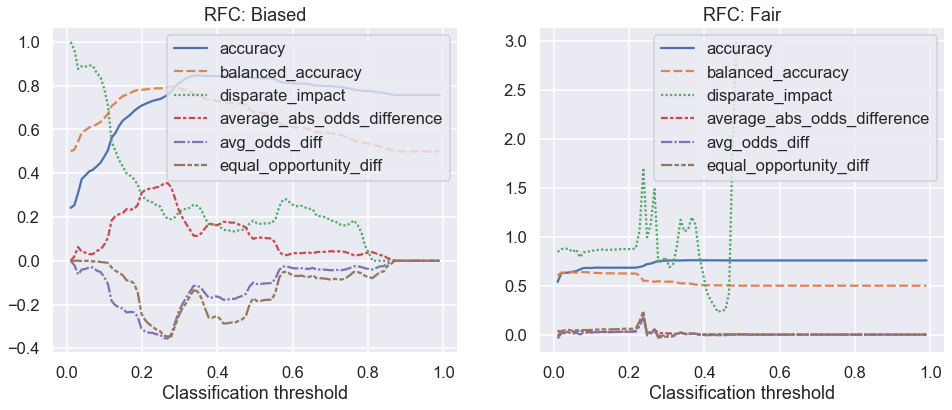

In [31]:
# Plot for Random Forest Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(BiasedRfcModel, X_test, y_test), ax=ax[0], title="RFC: Biased")
    
    plot_metrics(calc_metrics(UnbiasedRfcModel, X_lfr_test, y_lfr_test), ax=ax[1], title="RFC: Fair")

In [32]:
display(Markdown("#### Individual fairness metrics"))
print("Consistency of labels in transformed training dataset= %f" %metric_train_lfr.consistency())
print("Consistency of labels in original training dataset= %f" %metric_train_bld.consistency())

#### Individual fairness metrics

Consistency of labels in transformed training dataset= 0.999729
Consistency of labels in original training dataset= 0.832631


In [33]:
# Check whether the transform on the original dataset has worked. 
# A false means that the dataset is transformed.
Adult_train_lfr_df.equals(Adult_train_df)

False

In [34]:
Adult_train_df     = Adult_train_df.reset_index(drop=True)
Adult_train_lfr_df = Adult_train_lfr_df.reset_index(drop=True)
AdultBool          = (Adult_train_df != Adult_train_lfr_df).stack()  # Create Frame of comparison booleans
Adultdiff          = pd.concat([Adult_train_df.stack()[AdultBool], Adult_train_lfr_df.stack()[AdultBool]], axis=1)
Adultdiff.columns  =["Adult_train_df", "Adult_train_lfr"]
print(Adultdiff)

                     Adult_train_df  Adult_train_lfr
0     Age                  0.068493         0.115632
      Employment           0.000000         0.091101
      Education            0.133333         0.198282
      EducationNum         0.733333        -0.231543
      MaritalStatus        0.000000         0.303097
      Occupation           0.461538         0.287310
      Relationship         0.000000        -0.064860
      Race                 0.250000         0.213134
      CapitalGain          0.000000        -0.614880
      CapitalLoss          0.000000        -0.216481
      HoursPerWeek         0.265306        -0.134670
      NativeCountry        0.000000         0.068121
1     Age                  0.082192        -0.420671
      Employment           0.500000         0.113040
      Education            0.066667         0.259477
      EducationNum         0.533333         0.360259
      MaritalStatus        0.000000        -0.686725
      Occupation           0.230769        -0.

In [35]:
## PCA Analysis of consitency

In [36]:
# At this stage the transformed dataframe will have the last threshold encountered!
feat_cols = Adult_train_bld.feature_names

orig_df = pd.DataFrame(Adult_train_bld.features,columns=feat_cols)
orig_df['label'] = Adult_train_bld.labels
orig_df['label'] = orig_df['label'].apply(lambda i: str(i))

transf_df = pd.DataFrame(Adult_train_lfr.features,columns=feat_cols)
transf_df['label'] = Adult_train_lfr.labels
transf_df['label'] = transf_df['label'].apply(lambda i: str(i))

In [37]:
from sklearn.decomposition import PCA

orig_pca = PCA(n_components=3)
orig_pca_result = orig_pca.fit_transform(orig_df[feat_cols].values)

orig_df['pca-one'] = orig_pca_result[:,0]
orig_df['pca-two'] = orig_pca_result[:,1] 
orig_df['pca-three'] = orig_pca_result[:,2]

display(Markdown("#### Original training dataset"))
print('Explained variation per principal component:')
print(orig_pca.explained_variance_ratio_)

#### Original training dataset

Explained variation per principal component:
[0.39535937 0.1108289  0.09636189]


In [38]:
transf_pca = PCA(n_components=3)
transf_pca_result = transf_pca.fit_transform(transf_df[feat_cols].values)

transf_df['pca-one'] = transf_pca_result[:,0]
transf_df['pca-two'] = transf_pca_result[:,1] 
transf_df['pca-three'] = transf_pca_result[:,2]

display(Markdown("#### Transformed training dataset"))
print('Explained variation per principal component:')
print(transf_pca.explained_variance_ratio_)

#### Transformed training dataset

Explained variation per principal component:
[0.61902951 0.33977238 0.04119391]


In [39]:
###Load, clean up original test data and compute metric

In [40]:
display(Markdown("#### Testing Dataset shape"))
print(Adult_test_bld.features.shape)

metric_test_bld = BinaryLabelDatasetMetric(Adult_test_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_test_bld.mean_difference())

#### Testing Dataset shape

(9769, 13)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.200836


In [41]:
###Transform test data and compute metric

In [42]:
Adult_test_lfr = TR.transform(Adult_test_bld, threshold=threshold)
metric_test_lfr = BinaryLabelDatasetMetric(Adult_test_lfr, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

In [43]:
print("Consistency of labels in tranformed test dataset= %f" %metric_test_lfr.consistency())

Consistency of labels in tranformed test dataset= 0.999243


In [44]:
print("Consistency of labels in original test dataset= %f" %metric_test_bld.consistency())

Consistency of labels in original test dataset= 0.821722


In [45]:
def check_algorithm_success():
#   """Transformed dataset consistency should be greater than original dataset."""
    assert metric_test_lfr.consistency() > metric_test_bld.consistency(), "Transformed dataset consistency should be greater than original dataset."
print(check_algorithm_success())

None


In [46]:
# Is it possible to predict the Sensitive Variable from the transformed dataset
X_se_train = Adult_train_lfr_df.drop(protected_attr,axis=1)
y_se_train = Adult_train_lfr_df[protected_attr]
X_se_test  = Adult_test_df.drop(protected_attr,axis=1)
y_se_test  = Adult_test_df[protected_attr]
Se_UnbiasedLogModel = LogisticRegression(random_state=101)
Se_UnbiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_UnbiasedLogModel.fit(X_se_train, y_se_train) 
Se_UnbiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_UnbiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_UnbiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_UnbiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_UnbiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.35326031323574575
Biased Random Forest       validation accuracy: 0.3227556556454089

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.47905472171317276
Biased Random Forest       balanced accuracy  : 0.43628193832101014


In [47]:
# Lastly get the number of labels from the training dataset
print('Train df After - Income value counts:')
print(Adult_train_lfr_df.Income.value_counts())
print('Train df After - Gender value counts:')
print(Adult_train_lfr_df.Gender.value_counts())

Train df After - Income value counts:
0.0    38805
1.0      268
Name: Income, dtype: int64
Train df After - Gender value counts:
1.0    26143
0.0    12930
Name: Gender, dtype: int64
